In [1]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.layers import MaxPooling2D, Convolution2D, Flatten
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint   
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import cv2
import pandas as pd
import tensorflow as tf
from sklearn.datasets import load_files
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

Using TensorFlow backend.


In [29]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(data['target'], 133)
    return dog_files, dog_targets

### Dog dataset

In [30]:
test_files, test_targets = load_dataset('dog-project/dogImages/test/')
train_files, train_targets = load_dataset('dog-project/dogImages/train')
valid_files, valid_targets = load_dataset('dog-project/dogImages/valid')
total_img = len(test_files) + len(train_files) + len(valid_files)

print('Dog categoris: {}'.format(len(test_targets[0])))
print('Dog images: {}'.format(total_img))

print('Training images: {}'.format(len(train_files)))
print('Testing images: {}'.format(len(test_files)))
print('Validation images: {}'.format(len(valid_files)))


Dog categoris: 133
Dog images: 8351
Training images: 6680
Testing images: 836
Validation images: 835


In [31]:
np.shape(cv2.imread(train_files[0]))

(427, 640, 3)

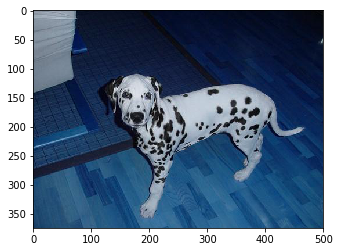

In [32]:
plt.imshow(cv2.imread(test_files[0]))
plt.show()

### Human Dataset

In [35]:
h_data = np.array(glob('dog-project/lfw/*/*'))
print('Human images: {}'.format(np.shape(h_data)[0]))

Human images: 13235


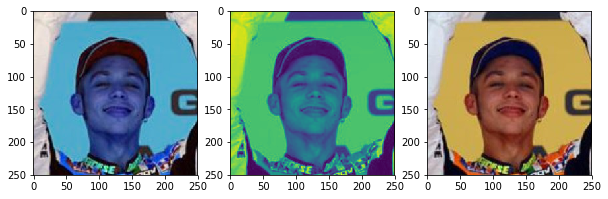

In [42]:
img = cv2.imread(h_data[100])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(gray)
plt.subplot(133)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

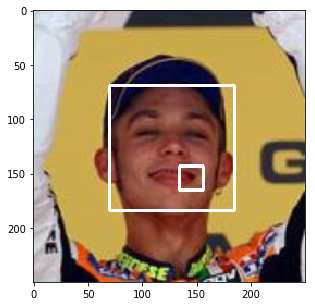

In [43]:
face_cas = cv2.CascadeClassifier('dog-project/haarcascades/haarcascade_frontalface_alt.xml')
eye_cas = cv2.CascadeClassifier('dog-project/haarcascades/haarcascade_eye.xml')
faces = face_cas.detectMultiScale(gray)
eyes = eye_cas.detectMultiScale(gray)
for x, y, w, h in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)
    
    for x, y, w, h in eyes:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
def verify_face_exist(file):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return len(face_cas.detectMultiScale(gray)) > 0

In [ ]:
undetected_human_face = sum([1 for i in h_data if not verify_face_exist(i)])
undetected_dog_face = sum([1 for i in train_files if not verify_face_exist(i)])
precentage_human = undetected_human_face / len(h_data)
precentage_dog = undetected_dog_face / len(train_files)
print('Missing faces\nHuman: {}({}%) Dog: {}({}%)'.format(undetected_human_face, precentage_human,
                                                          undetected_dog_face, precentage_dog))

### Keras

In [ ]:
from keras.applications.resnet50 import ResNet50
res_net = ResNet50(weights='imagenet')

In [ ]:
np.shape(cv2.imread(train_files[0]))

In [13]:
from keras.preprocessing import image
def path_to_tensor(path):
    img = image.load_img(path, target_size=[224, 224])
    img = image.img_to_array(img, 'channels_last')
    return np.expand_dims(img, axis=0)

In [ ]:
np.shape(path_to_tensor(train_files[0]))

In [ ]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y = np.array([[0], [1], [1], [0]], dtype=np.float32)
print('X: {}, y: {}'.format(np.shape(X), np.shape(y)))

In [ ]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1]))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('softmax'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics= ["accuracy"])
model.summary()
model.fit(X, y, epochs=1000, verbose=0)
model.evaluate(X, y)[-1]
#model.predict_proba(X)

### Mini_Project Student_Admissions

In [ ]:
df = pd.read_csv('aind2-dl/student_data.csv')
df.head()

Plotting GRE and GPA scores based on being admitted (cyan) or rejected (red)

In [ ]:
def plot_df(df):
    admitted = df[df['admit'] == 1]
    rejected = df[df['admit'] == 0]
    plt.scatter(admitted['gre'], admitted['gpa'], s=25, color='red', edgecolor='k')
    plt.scatter(rejected['gre'], rejected['gpa'], s=25, color='cyan', edgecolor='k')
    plt.xlabel('GRE')
    plt.ylabel('GPA')

plot_df(df)
plt.title('Potential UCLA Students')
plt.show()

Seperate the plot by ranks

In [ ]:
rank_1 = df[df['rank'] == 1]
rank_2 = df[df['rank'] == 2]
rank_3 = df[df['rank'] == 3]
rank_4 = df[df['rank'] == 4]
plot_df(rank_1)
plt.show()
plot_df(rank_2)
plt.show()
plot_df(rank_3)
plt.show()
plot_df(rank_4)
plt.show()

Preprocess the data, by normalizing the data and get_dummies

In [ ]:
def normalize(df, cols):
    for i in cols:
        df[i] = df[i]/df[i].max()
    return df

In [ ]:
df = normalize(df, ['gre', 'gpa'])
df = pd.get_dummies(df, columns=['rank'])
assert df['gre'].max() == 1
assert df['gpa'].max() == 1

One hot incode the admit colum

In [ ]:
X = np.array(df.drop('admit', axis=1))
y = np_utils.to_categorical(np.array(df['admit']))
assert X.shape == (len(df), len(df.columns)-1)
assert y.shape == (len(df), 2)

In [ ]:
X_train, X_test, y_train, y_test = X[50:], X[:50], y[50:], y[:50]
print('X_train: {}'.format(X_train.shape))
X[:10]

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=X.shape[-1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[-1], activation='sigmoid'))
model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metric=["accuracy"])
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=200, batch_size=50, verbose=False)
model.evaluate(X_test, y_test)

## IMDB Movie Data

Load data from keras

In [ ]:
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

### Preprocessing

In [ ]:
np_y_train, np_y_test  = np.eye(max(y_train)+1)[y_train], np.eye(max(y_test)+1)[y_test]
assert np_y_train.shape == (25000, 2) == np_y_test.shape == (25000, 2)

In [ ]:
k_y_train, k_y_test = np_utils.to_categorical(y_train, 2), np_utils.to_categorical(y_test, 2)
assert k_y_train.shape == (25000, 2) == k_y_test.shape == (25000, 2)

np.testing.assert_array_equal(np_y_train, k_y_train)
np.testing.assert_array_equal(np_y_test, k_y_test)

In [ ]:
token = Tokenizer(num_words=1000)
x_train, x_test = token.sequences_to_matrix(x_train, mode='binary'), token.sequences_to_matrix(x_test, mode='binary')

In [ ]:
model = Sequential()
model.add(Dense(1024, input_dim=x_train.shape[-1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(np_y_train.shape[-1], activation='softmax'))

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metric=['accuracy'])
model.fit(x_train, np_y_train, epochs=100, batch_size=512, validation_split=0.2, verbose=1, shuffle=True)

In [ ]:
model.evaluate(x_test, np_y_test, verbose=1)

### MNIST Dataset

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Number of training examples: {}'.format(X_train.shape[0]))
print('Number of testing examples: {}'.format(X_test.shape[0]))

Number of training examples: 60000
Number of testing examples: 10000


In [6]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [7]:
X_train, X_test = X_train/255, X_test/255
y_train , y_test = np_utils.to_categorical(y_train, 10), np_utils.to_categorical(y_test, 10)

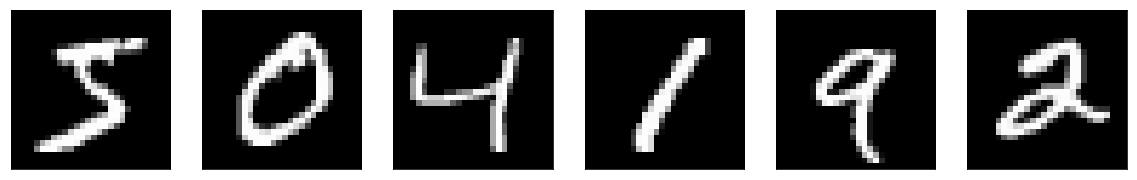

In [8]:
fig = plt.figure(figsize=(20,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')
plt.show()

In [23]:
XX_train = X_train.reshape((1,) + X_train.shape)
XX_test = X_test.reshape((1,) + X_test.shape)
XX_train.shape

(1, 60000, 28, 28)

In [11]:
def img_to_tensor(img_path):
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    return np.expand_dims(img, axis=0)

def images_to_tensor(img_paths):
    return np.vstack([img_to_tensor(img) for img in img_paths])

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True  

X_train, X_test = images_to_tensor(X_train), images_to_tensor(X_test)

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [27]:
model = Sequential()
model.add(Convolution2D(32, kernel_size=2, strides=1, padding='same', activation='relu', input_shape=(28, 28)))
model.add(Convolution2D(64, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(Convolution2D(128, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Convolution2D(32, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(Convolution2D(64, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(Convolution2D(128, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='softmax'))
model.add(Dense(10, activation='softmax'))
model.summary()

ValueError: Input 0 is incompatible with layer conv2d_7: expected ndim=4, found ndim=3

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metric=['accuracy'])
model.fit(XX_train, y_train, epochs=100, batch_size=512, validation_split=0.2, verbose=1, shuffle=True)

ValueError: Error when checking model input: expected conv2d_1_input to have shape (None, 28, 28, 1) but got array with shape (1, 60000, 28, 28)

### Cifar-10 Dataset

In [5]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

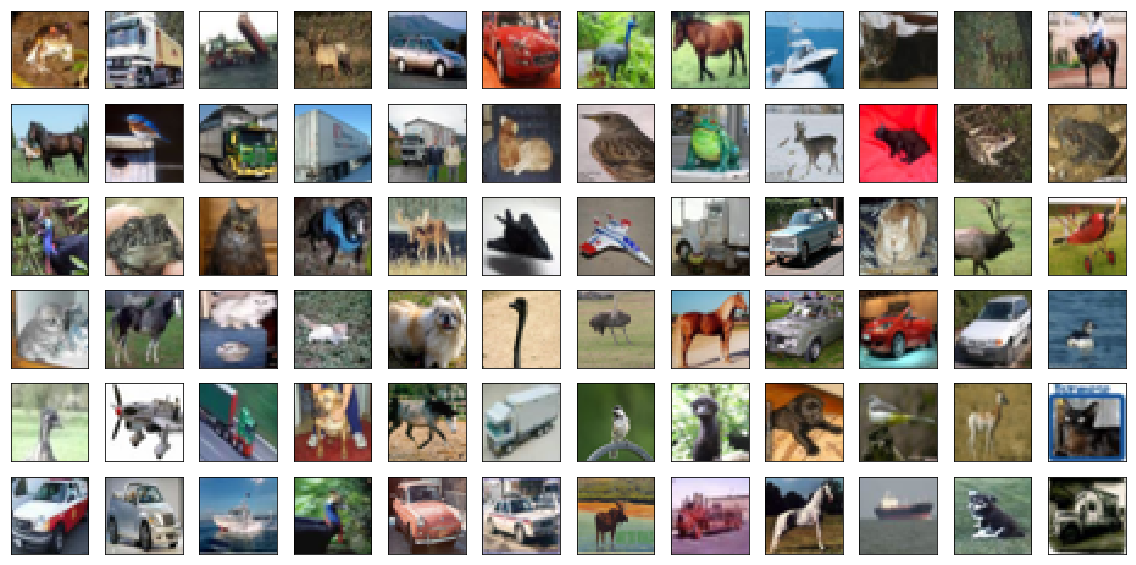

In [6]:
fig = plt.figure(figsize=(20,10))
for i in range(72):
    ax = fig.add_subplot(6, 12, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i])
plt.show()

In [7]:
num_class = len(np.unique(y_train))
x_train, x_test = x_train/255, x_test/255
y_train , y_test = np_utils.to_categorical(y_train, 10), np_utils.to_categorical(y_test, 10)

In [20]:
model = Sequential()
model.add(Convolution2D(32, kernel_size=2, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Convolution2D(64, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Convolution2D(32, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(Convolution2D(64, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Convolution2D(32, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(Convolution2D(64, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        8224      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          8224      
__________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metric=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.weights.best.hdff5', verbose=1, save_best_only=True)
hist = model.fit(x_train, y_train, epochs=20, batch_size=256, validation_split = 0.2, 
                 callbacks=[checkpoint], verbose=1, shuffle=True)

/home/ksooklall/anaconda3/envs/aind-dog/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 40000 samples, validate on 10000 samples
Epoch 1/20


In [ ]:
model.load_weights('model.weights.best.hdff5')

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

In [ ]:
y_hat = model.predict(x_test)

In [ ]:
%matplotlib inline
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=(20,10))
for i, v in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[v])
    pred_idx = np.argmax(y_hat[v])
    true_idx = np.argmax(y_test[v])
    ax.set_title("{},({})".format(labels[pred_idx], labels[true_idx]), color=('green' if true_idx == pred_idx else 'red'))
plt.show()

### RNN Example 1

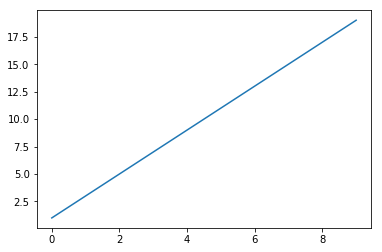

In [7]:
seq = np.arange(1, 20 ,2)
plt.plot(seq)
plt.show()

In [23]:
def windows(X, window_size):
    x = []
    y = []
    
    for i in range(len(X)-window_size):
        x.append(X[i:i+window_size])
        y.append(X[i+window_size])
    return np.squeeze(x), np.squeeze(y)

In [43]:
X, y = windows(seq, 1)

In [57]:
model = Sequential()
#model.add(Dense(100, input_dim=1, activation='linear'))
model.add(Dense(1, input_dim=1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 2         
Total params: 2.0
Trainable params: 2
Non-trainable params: 0.0
_________________________________________________________________


In [58]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [66]:
model.fit(X, y, epochs=3000, verbose=0)

In [71]:
model.predict(np.array([27]))

array([[ 29.06007004]], dtype=float32)

In [72]:
weights = model.get_weights()
weights

[array([[ 1.00392199]], dtype=float32), array([ 1.95417535], dtype=float32)]